In [1]:
#Time series and visualization packages
from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import pandas as pd
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

#possible forecasting through machine learning
import xgboost as xgb

#misc
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

C:\Anaconda\envs\jupyter\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
fero = pd.read_csv("FOE.csv")

In [3]:
#Taking a look at our data
fero.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-03-17,0.0,2.722222,2.685185,2.685185,1.450476,47925
1,1980-03-18,0.0,2.703704,2.666667,2.685185,1.450476,77625
2,1980-03-19,0.0,2.703704,2.666667,2.703704,1.460480,35775
3,1980-03-20,0.0,2.777778,2.703704,2.722222,1.470483,42525
4,1980-03-21,0.0,2.777778,2.740741,2.740741,1.480487,37125


In [4]:
#numerical value summary statistics
fero[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].describe()

,Open,High,Low,Close,Adj Close,Volume
count,10590.000000,10590.000000,10590.000000,10590.000000,10590.000000,1.059000e+04
mean,13.607281,14.631222,14.240872,14.439353,11.952665,3.662785e+05
std,8.521814,7.381201,7.230212,7.309994,6.597625,6.056098e+05
min,0.000000,1.010000,0.810000,0.860000,0.860000,0.000000e+00
25%,7.072500,7.740000,7.420000,7.611111,5.995661,7.695000e+04
50%,14.860000,15.080000,14.666667,14.865000,12.818146,1.966500e+05
75%,20.610001,20.847500,20.333332,20.620001,17.534573,4.675750e+05
max,30.250000,30.937500,30.000000,30.549999,25.350000,2.044590e+07


In [5]:
#converting the Date into datetime
fero.Date = pd.to_datetime(fero.Date, format='%Y-%m-%d')
fero.Close = fero.Close.astype(float)

In [6]:
#Five year subset with ontly Date and Close columns
fero_sub = fero[['Date', 'Close']]
fero_sub = fero_sub.loc[(fero_sub['Date'] >= '2016-01-01')]
fero_sub.index = fero_sub.Date

In [7]:
fero_sub

,Date,Close
Date,,
2016-01-04,2016-01-04,10.750000
2016-01-05,2016-01-05,10.580000
2016-01-06,2016-01-06,10.050000
2016-01-07,2016-01-07,9.520000
2016-01-08,2016-01-08,9.610000
...,...,...
2022-03-09,2022-03-09,21.780001
2022-03-10,2022-03-10,21.790001
2022-03-11,2022-03-11,21.780001


In [8]:
#extracting days, month and year
fero_sub['year'] = fero_sub.Date.dt.year
fero_sub['month'] = fero_sub.Date.dt.month
fero_sub['day'] = fero_sub.Date.dt.day
fero_sub.head()

,Date,Close,year,month,day
Date,,,,,
2016-01-04,2016-01-04,10.75,2016,1,4
2016-01-05,2016-01-05,10.58,2016,1,5
2016-01-06,2016-01-06,10.05,2016,1,6
2016-01-07,2016-01-07,9.52,2016,1,7
2016-01-08,2016-01-08,9.61,2016,1,8


<AxesSubplot:xlabel='month'>

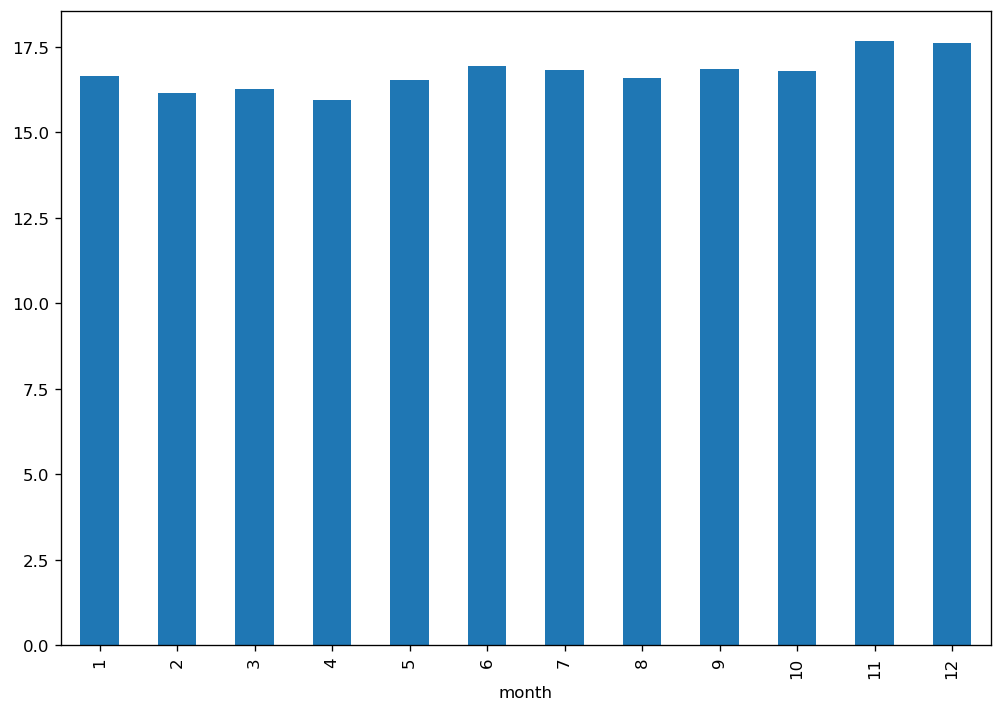

In [9]:
#Average price per month
fero_sub.groupby('month').Close.mean().plot.bar()

<AxesSubplot:xlabel='year'>

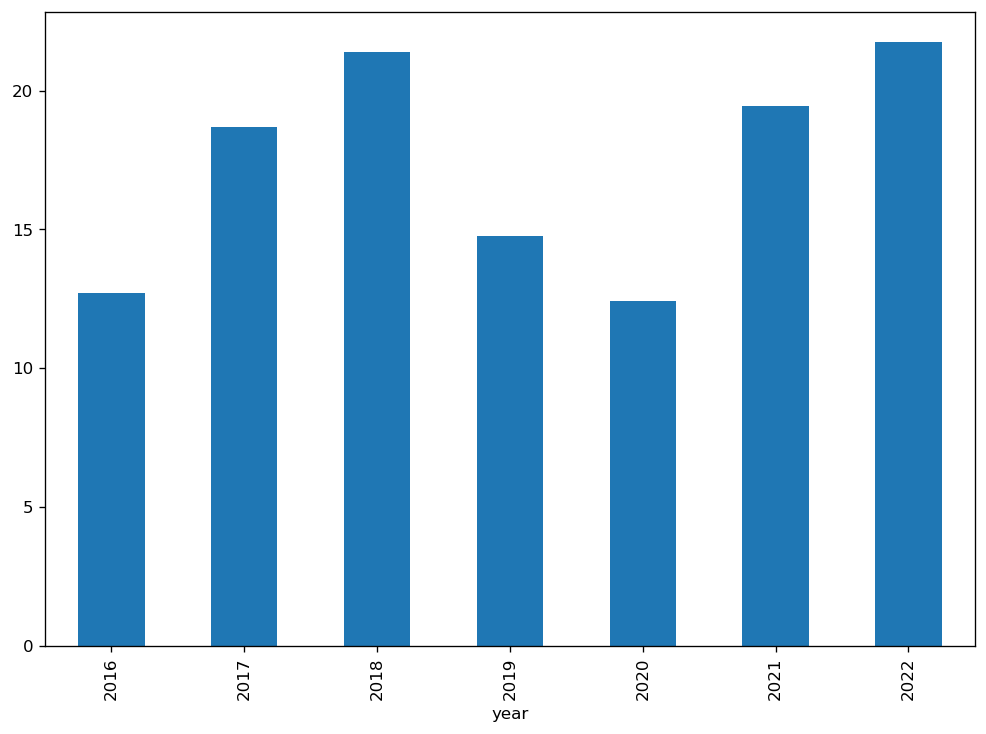

In [10]:
#Average price per year
fero_sub.groupby('year').Close.mean().plot.bar()

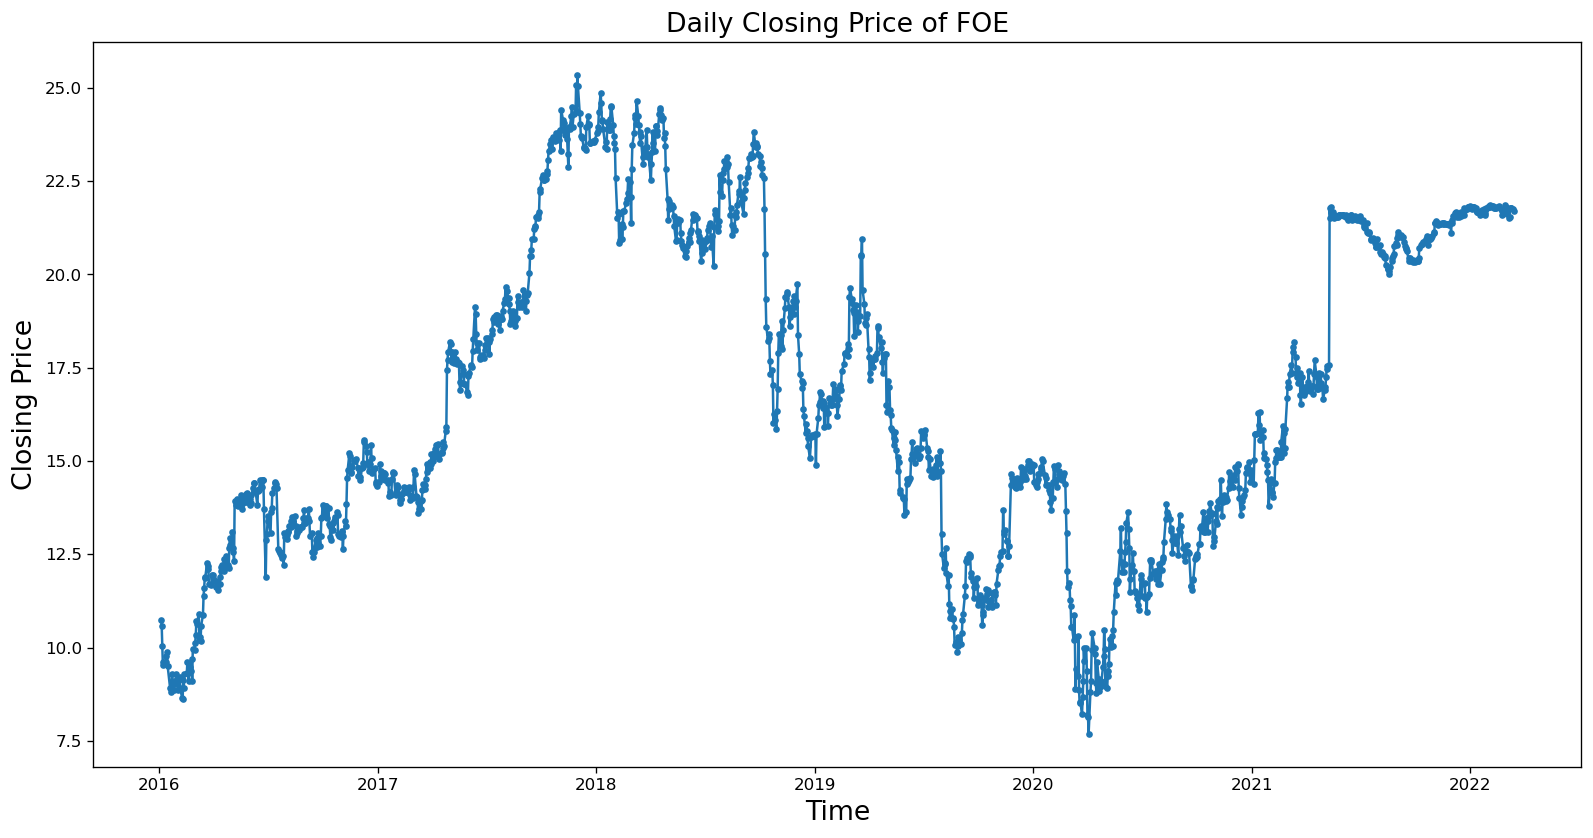

In [11]:
#function to plot a line graph
def line_g(df,x,y,title):
    plt.figure(figsize=(16,8))
    plt.plot(x, y, ".-", data = df)
    plt.title(title, fontsize = 16)
    plt.xlabel("Time", fontsize = 16)
    plt.ylabel("Closing Price", fontsize = 16)
line_g(fero_sub,'Date', 'Close', "Daily Closing Price of FOE")

In [12]:
monthly = fero_sub.resample('M').sum()
monthly

,Close,year,month,day
Date,,,,
2016-01-31,180.130000,38304,19,312
2016-02-29,184.520000,40320,40,284
2016-03-31,247.230000,44352,66,343
2016-04-30,254.100000,42336,84,331
2016-05-31,287.390000,42336,105,321
...,...,...,...,...
2021-11-30,447.960000,42441,231,304
2021-12-31,476.139995,44462,264,352
2022-01-31,434.409994,40440,20,324


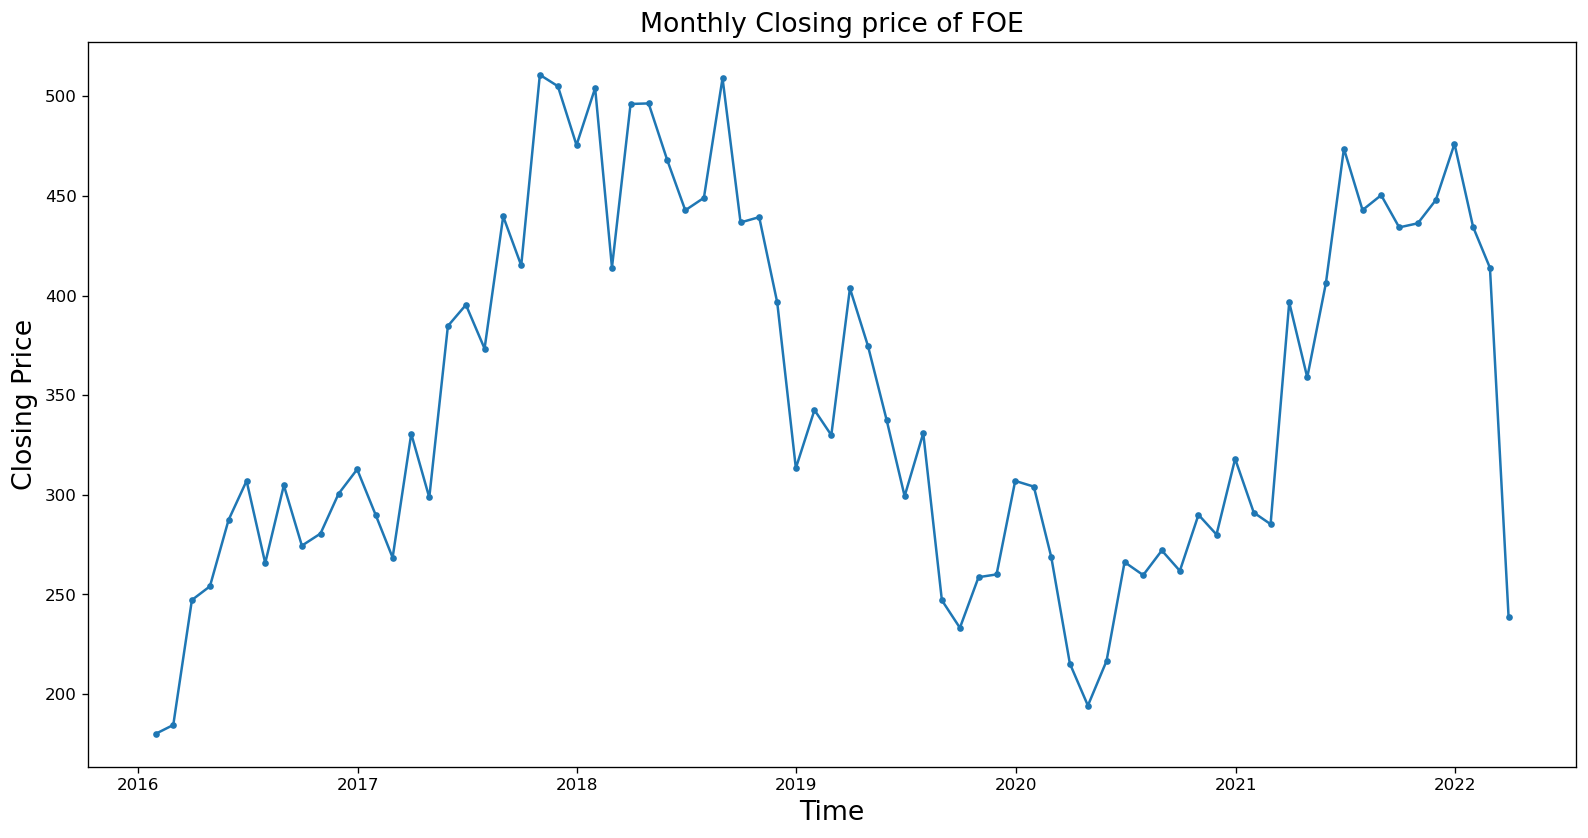

In [13]:
line_g(monthly, monthly.index, 'Close', "Monthly Closing price of FOE")

In [17]:
#monthly subset
monthly_sub = monthly.loc[(monthly.index <= '2021-01-01')]
len(monthly_sub)

60

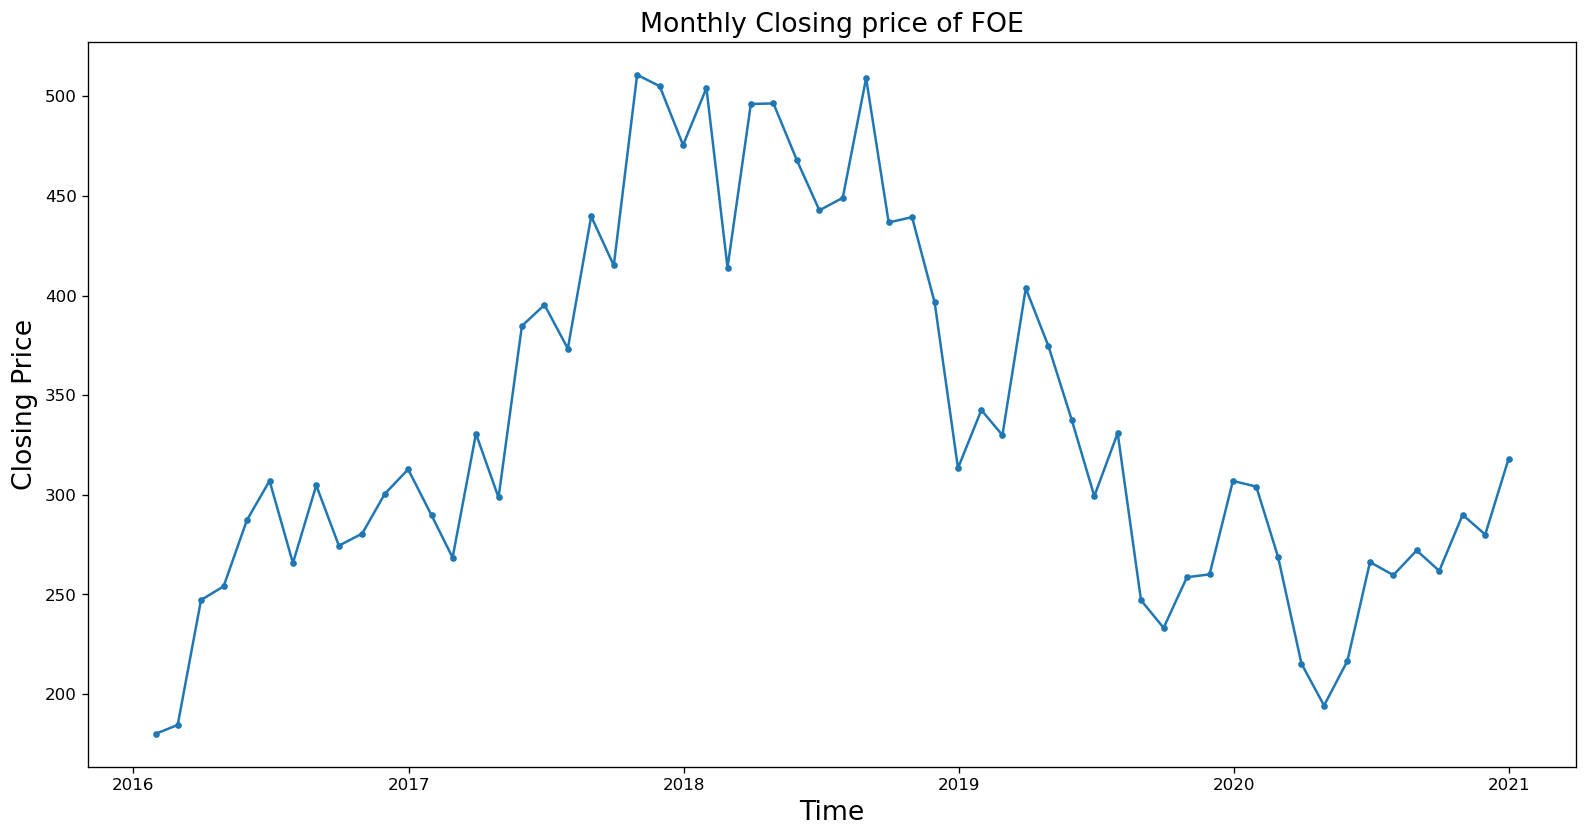

In [18]:
line_g(monthly_sub, monthly_sub.index, 'Close', "Monthly Closing price of FOE")

In [20]:
# DF Test using statsmodels adfuller
from statsmodels.tsa.stattools import adfuller

def df_test(time_series):
    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(time_series, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    
    print (dfoutput)
df_test(monthly_sub.Close)

Results of Dickey-Fuller Test:
Test Statistic                 -1.943846
p-value                         0.311724
#Lags Used                      1.000000
Number of Observations Used    58.000000
Critical Value (1%)            -3.548494
Critical Value (5%)            -2.912837
Critical Value (10%)           -2.594129
dtype: float64
